In [1]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")

In [ ]:
import os
# Change to the directory of the current file
os.chdir(r"D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz")
import numpy as np 
import pandas as pd 
from LopezRandomMethod import random_gen_weights
from unitCircle import unitCircle as unitCircleDf
import matplotlib.pyplot as plt
from function_filePrep import tickerList, download_data,missing_days_andIndexTimeZone, to_month_and_add_monthYear_columns
np.random.seed(1986)


The current working directory is: D:\MyDrive\10. MS in Data Science UofWisconsin\14. Capstone Code\Markowitz


Creating Random Weights Df and Dataframe of Daily Returns

In [4]:
np.random.seed(1986)
n_rows = 10000
n_cols = 30
data = []
data_uniform= []

for _ in range(n_rows):
    row = random_gen_weights(n_cols)       
    data.append(row)
data.append([1/30]*30)

#downloading only last year as I believe is more representative of the picture going forward
df_weights = pd.DataFrame(data)
df_ticker_price = download_data(list_stocks=tickerList,start_date = '2023-08-01', end_date = '2024-09-30')
df_ticker_price1=missing_days_andIndexTimeZone(df_ticker_price)
#os.chdir(os.path.dirname(os.path.abspath(__file__)))


#%%
## 41 rows of daily pct change in aug and sept 2024
training_1y_endJul2024=df_ticker_price1[:"2024-07-31"].copy()

training_pct_change=training_1y_endJul2024.pct_change().dropna()

[*********************100%***********************]  30 of 30 completed


Observing Sharpe Ratio for DJI

In [21]:
weights_DJI=training_1y_endJul2024 >> filter(_.index == _.index.max()) >> _.apply(lambda x: x/sum(x), axis=1) >> _.iloc[0,:]

In [23]:
mean_DJI = training_pct_change.dot(weights_DJI).mean()*41
sd_DJI = training_pct_change.dot(weights_DJI).std()*np.sqrt(41)

print(f"Sharpe DJI = {mean_DJI/sd_DJI}")

Sharpe DJI = 0.7791621278111761


Calculating Sharpe Ratio for Every Single Randomly Created Portfolio

In [ ]:
port_means= []
port_sd = []
for row in df_weights.values: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    port_means.append(i_mean*41) # times 41 to get expected return in 41 days (2 months)
    port_sd.append(i_sd * np.sqrt(41))
    
#%%
#renaming columns and adding sharpe ratio
df_weights.columns = training_pct_change.columns
df_weights['port_return'] = port_means
df_weights['port_risk'] = port_sd
df_weights['sharpe'] = df_weights['port_return']/df_weights['port_risk']

How much better is the Best Random Portfolio vs DJI

In [25]:
df_weights.sharpe.max()/(mean_DJI/sd_DJI)

1.3838680080227685

**Notice that we are using Constraint and Bounds**: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

- sum == 1 
    -  this parameter is only used if we use SLSQP (Sequential Least Squares Programming)
- From Scipy documentation: <br>
    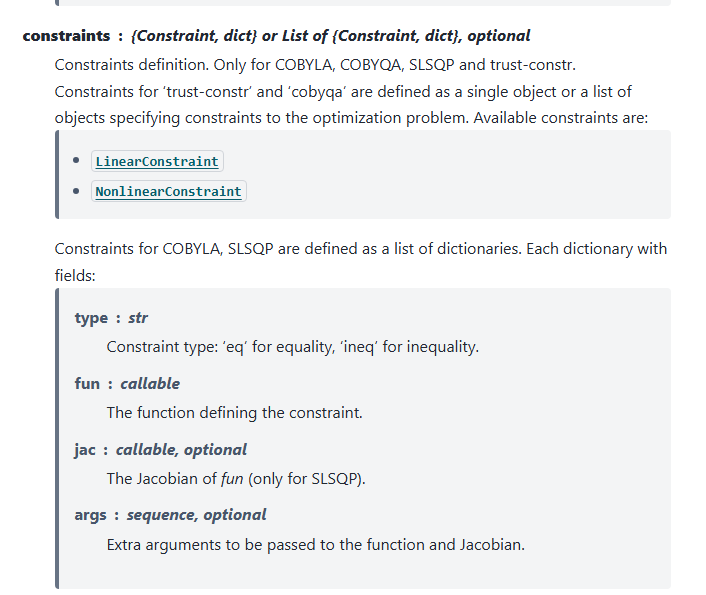 <br>
- Parameters: [0,1] <br>
    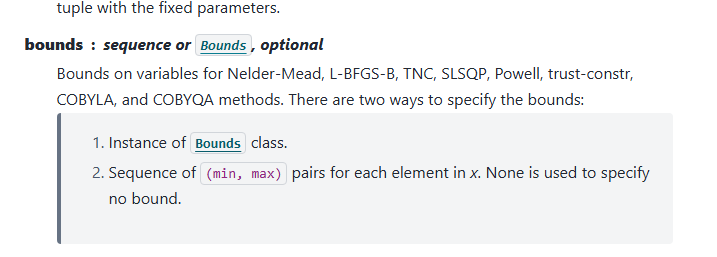

In [6]:
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41 # times 41 b/c there are 41 trading days in August and Sept

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    #returns negative because we will use scipy.optimize.minimize
    return - (port_return - risk_free_rate) / port_risk

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0, 1) for _ in range(training_pct_change.shape[1])]


## Result from Minimize

In [7]:
# Set display option for pandas
pd.set_option('display.max_columns', 500)

In [7]:
metoFila = []
for _iterRow in df_weights.values: 
    first30 = _iterRow[:30]
    totalTrue = 0
    for value in first30:
        if value == 1/30:
            totalTrue+=1
    if totalTrue == 30: 
        metoFila.append(_iterRow)

In [10]:
from plotnine import * 
from siuba import * 
from siuba.dply.vector import * 

In [39]:
df_small_DJI=pd.DataFrame({'x': [sd_DJI], 'y': [mean_DJI]} )

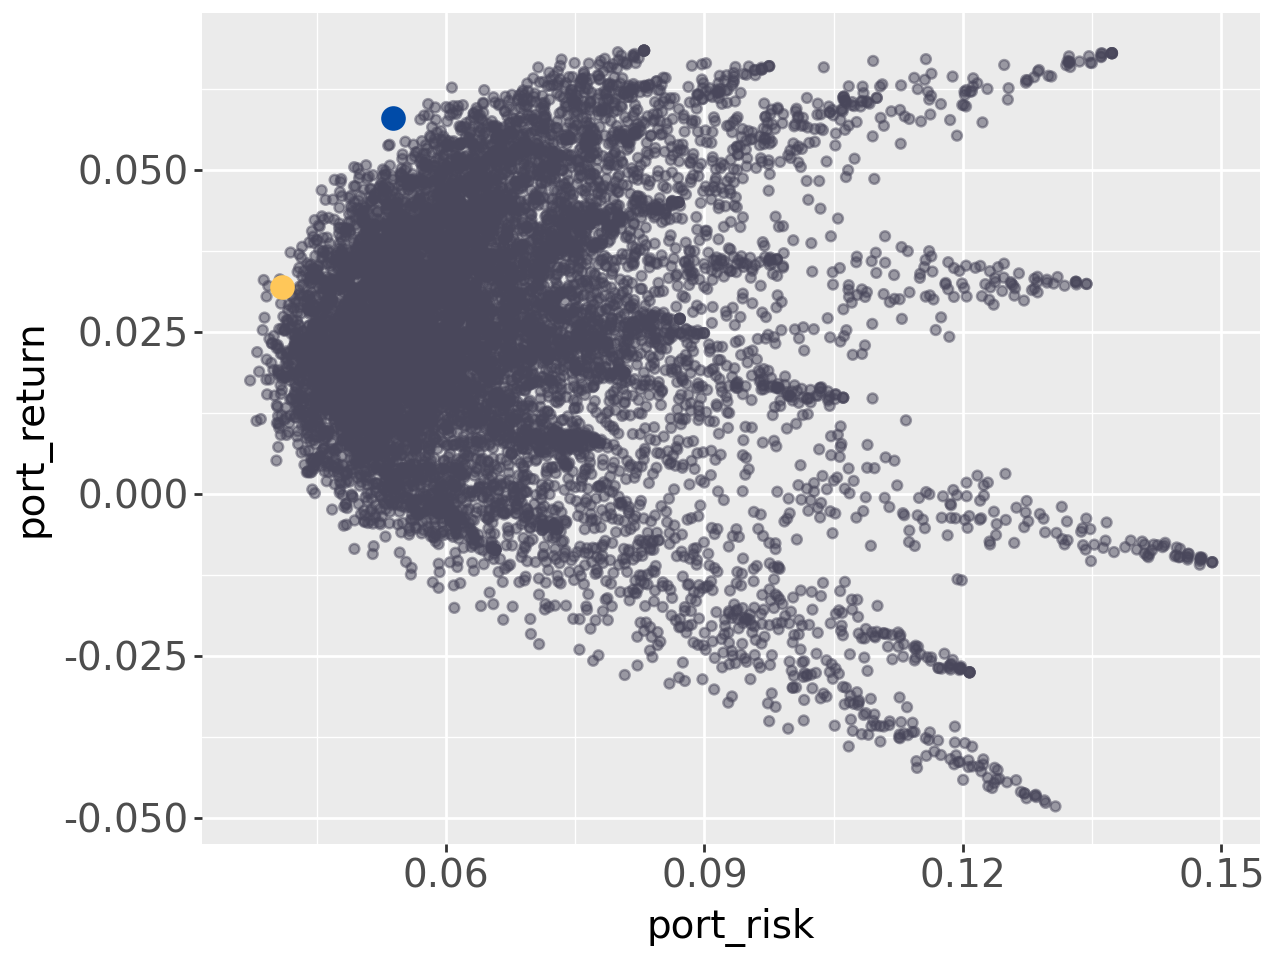

In [57]:
risk_vs_return_graph=df_weights >> ggplot() + geom_point(aes(x='port_risk', y = 'port_return'), alpha=0.5, color = '#49475B' ) + \
geom_point(df_small_DJI,aes(x='x',y='y'), color='#FFC759', size=4 ) + \
    geom_point(df_weights >> arrange(-_.sharpe) >> head(1), aes(x='port_risk', y = 'port_return'), size=4, color = '#004BA8')+\
    theme(text=element_text(family='sans-serif',size=14)      
    )

risk_vs_return_graph


In [55]:
risk_vs_return_graph.save('risk vs return graph',dpi=1000)

In [8]:
#initial_guess = [1. / returns.shape[1]] * returns.shape[1]
initial_guess = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:].to_list()
from scipy.optimize import minimize
result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)

print("Optimized Weights:", result.x)
print("Maximized Sharpe Ratio:", -result.fun)


Optimized Weights: [1.84586166e-16 1.07286029e-01 7.53231935e-02 9.05412872e-02
 5.94328984e-16 9.77851582e-17 9.35310523e-17 3.97593356e-16
 9.43956351e-17 3.23774036e-16 5.07766945e-16 2.61835790e-02
 1.70049368e-16 3.17142195e-17 9.70109548e-02 2.24890710e-16
 2.29139635e-16 1.22983472e-01 1.61385827e-17 3.96314224e-17
 3.60906885e-02 1.36492429e-16 5.43364178e-02 5.32489191e-16
 8.99360588e-17 3.28323213e-02 4.01207292e-02 8.30588029e-17
 1.12648354e-01 2.04642973e-01]
Maximized Sharpe Ratio: 1.2881774846264524


In [58]:
mean_SLSQP = training_pct_change.dot(result.x).mean()*41
sd_SLSQP = training_pct_change.dot(result.x).std()*np.sqrt(41)

In [60]:
df_small_SLSQP=pd.DataFrame({'x': [sd_SLSQP], 'y': [mean_SLSQP], 'port':['SLSQP']} )

In [66]:
beforeOptim=df_weights >> arrange(-_.sharpe) >> head(1) >> select(_.port_risk, _.port_return) >> rename(x = _.port_risk, y= _.port_return) >> mutate(port = 'beforeOptim')

In [71]:
df_small_DJI['port'] = ['DJI']

port_groups_df=pd.concat([df_small_DJI, df_small_SLSQP,beforeOptim])

array([], dtype=float64)

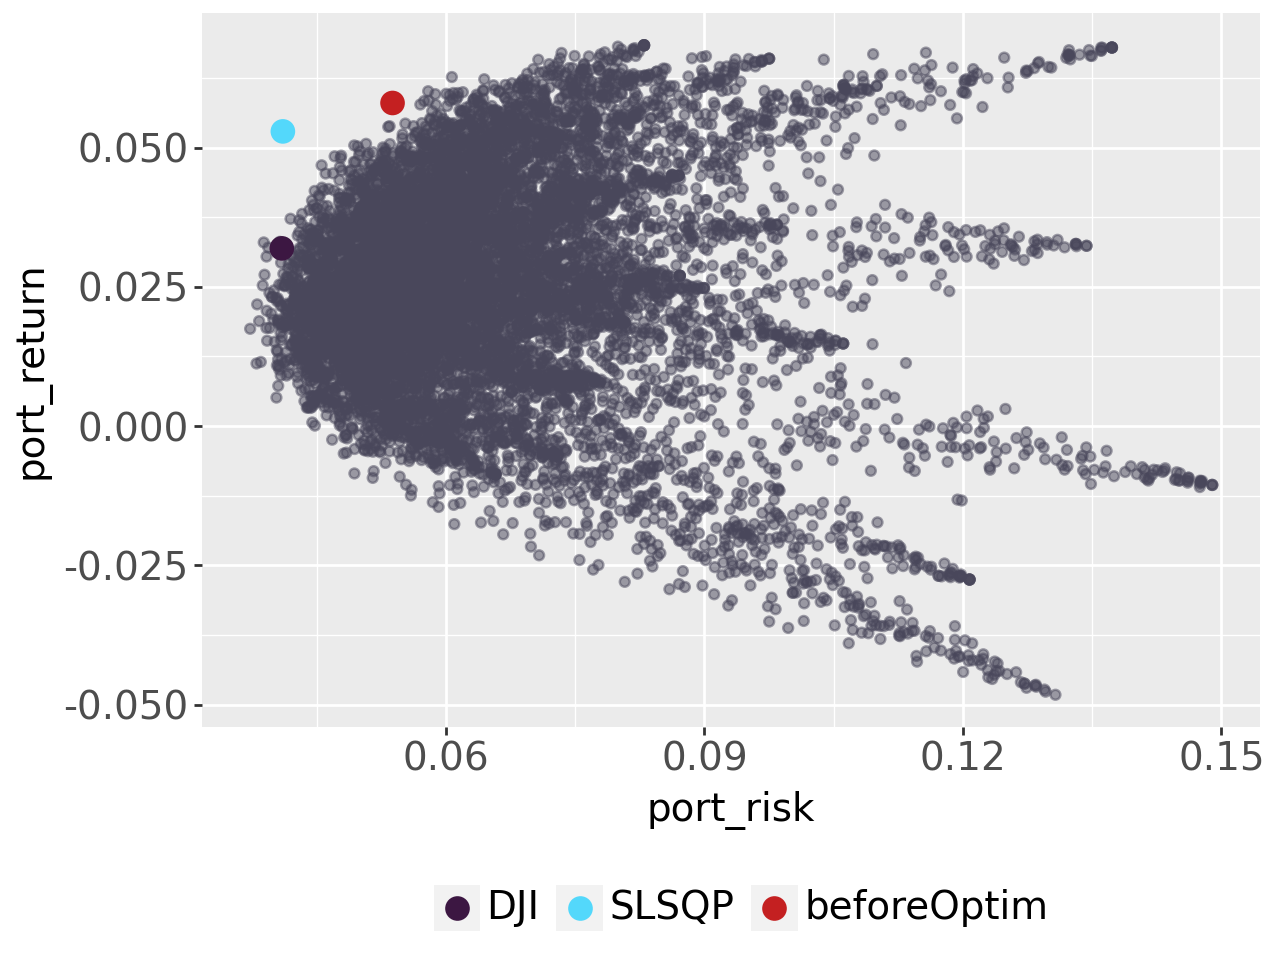

In [82]:
afterOptim1=df_weights >> ggplot() + geom_point(aes(x='port_risk', y = 'port_return'), alpha=0.5, color = '#49475B' ) + \
geom_point(port_groups_df,aes(x='x',y='y', color='port'), size=4 ) + scale_color_manual(
    name='\n',
    values={'DJI': '#3C1742', 'SLSQP': '#53D8FB', 'beforeOptim': '#C42021'},
    labels={'Lopez': 'Lopez', 'Stafford': 'Stafford', 'Uniform': 'Uniform'}
)    + \
    theme(text=element_text(family='sans-serif',size=14) ,legend_position= 'bottom') 

afterOptim1

In [83]:
afterOptim1.save('after Optim 1', dpi=1000)

akjlsdnfkjas

In [87]:

# recent weights DJI 
weights_DJI_recent=(df_ticker_price1.apply(lambda x: x/sum(x), axis=1) >> filter(_.index == '2024-09-27')).iloc[0,:]

#%%

y_recentDJI=np.array(weights_DJI_recent).dot(unitCircleDf['heights'])
x_recentDJI=np.array(weights_DJI_recent).dot(unitCircleDf['lengths'])


In [103]:
beforeOptimWeights=df_weights >> arrange(-_.sharpe) >> head(1) >> _.iloc[0,:30]

In [109]:
y_beforeOptim=np.array(beforeOptimWeights).dot(unitCircleDf.heights)
x_beforeOptim=np.array(beforeOptimWeights).dot(unitCircleDf.lengths)

In [112]:
y_SLSQP=np.array(result.x).dot(unitCircleDf.heights)
x_SLSQP=np.array(result.x).dot(unitCircleDf.lengths)

In [114]:
df_unitCircle_Ports1=pd.DataFrame({'x':[0, x_recentDJI,x_beforeOptim,x_SLSQP],'y':[0,y_recentDJI,y_beforeOptim,y_SLSQP],'Portfolios': ['Eq. Weight','DJI','beforeOptim','SLSQP']})

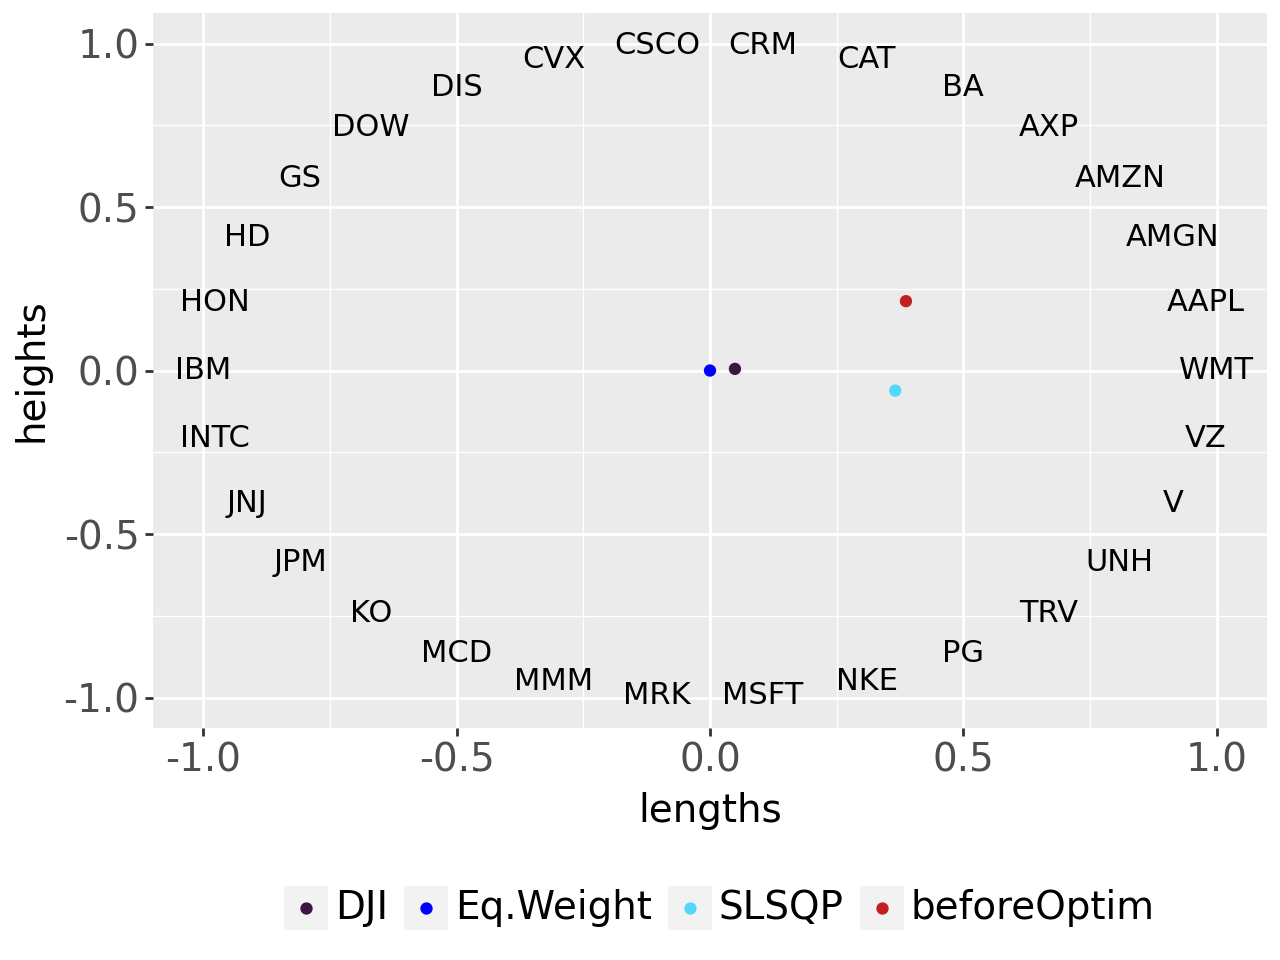

In [118]:
unitCircleGraph_optim1=unitCircleDf >> ggplot()+ \
geom_text(aes(x='lengths',y='heights',label='securities')) +\
geom_point(df_unitCircle_Ports1,aes(x='x', y='y', color='Portfolios')) + scale_color_manual(
    name='\n',
    values={'DJI': '#3C1742', 'SLSQP': '#53D8FB', 'beforeOptim': '#C42021','Eq. Weight':'blue'},
    labels={'Lopez': 'Lopez', 'Stafford': 'Stafford', 'Uniform': 'Uniform','Eq. Weight':'Eq.Weight'}
)    + \
    theme(text=element_text(family='sans-serif',size=14) ,legend_position= 'bottom') 

unitCircleGraph_optim1

In [119]:
unitCircleGraph_optim1.save('Unit Circle Graph Optim 1', dpi=1000)

In [ ]:
risk_vs_return_graph=df_weights >> ggplot() + geom_point(aes(x='port_risk', y = 'port_return'), alpha=0.5, color = '#49475B' ) + \
geom_point(df_small_DJI,aes(x='x',y='y'), color='#FFC759', size=4 ) + \
    geom_point(df_weights >> arrange(-_.sharpe) >> head(1), aes(x='port_risk', y = 'port_return'), size=4, color = '#004BA8')+\
    theme(text=element_text(family='sans-serif',size=14)      
    )

risk_vs_return_graph

Visualizing Best Weights

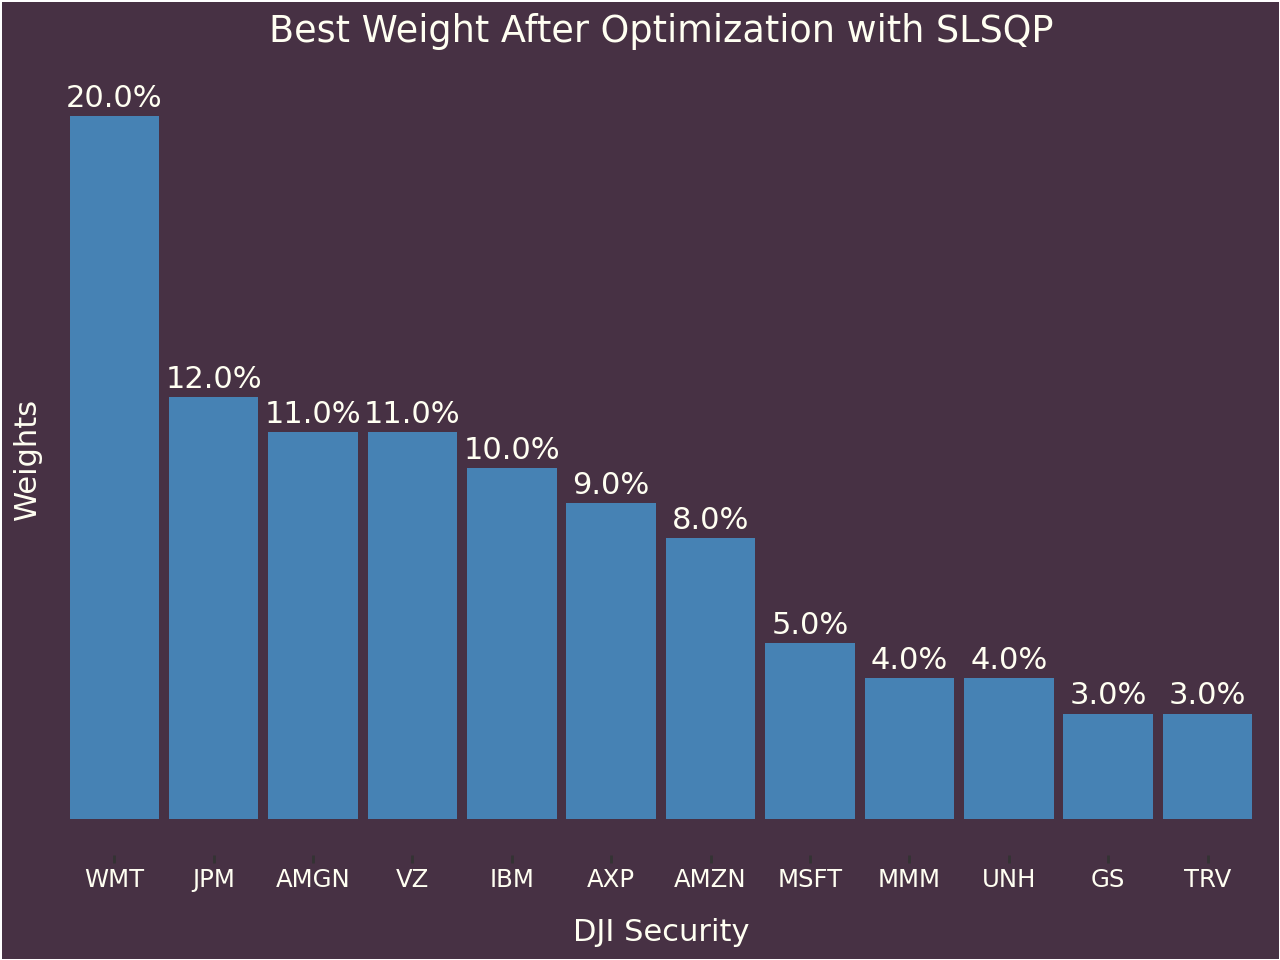

In [120]:
from siuba import * 
from plotnine import * 
from typing import Union


def viz_weights_barPlot(array_of_weights: Union[list[float], np.ndarray], title:str = 'Visualizing Weights'):
    return pd.DataFrame(np.round(array_of_weights,2).reshape(1,30), columns= df_weights.columns[:30])>> _.melt() >> filter(_.value > 0) >> \
    mutate(value_plot = _.value *100, 
        value_plot2 = (_.value *100).apply(lambda x: str(x) + '%') ) >> arrange(-_.value) >>\
        ggplot() + geom_col(aes(x='reorder(variable, -value)',y='value'), fill = 'steelblue') + \
            geom_text(aes(x='variable',y='value',label='value_plot2'), nudge_y =.005, color = '#FFFFF2') +\
            labs(y = 'Weights', x='DJI Security',title=title) + \
            theme(
                axis_text_y=element_blank(),
                axis_ticks_y=element_blank(), 
                plot_background=element_rect(fill='#473144'),
                panel_background=element_rect(fill='#473144'),
                text=element_text(color='#FFFFF2'),
                axis_title_x=element_text(margin={'t': 20}),   # Move x-axis label
                panel_grid_major= element_blank(),
                panel_grid_minor=element_blank()
            )

viz_weights_barPlot(result.x, title='Best Weight After Optimization with SLSQP')


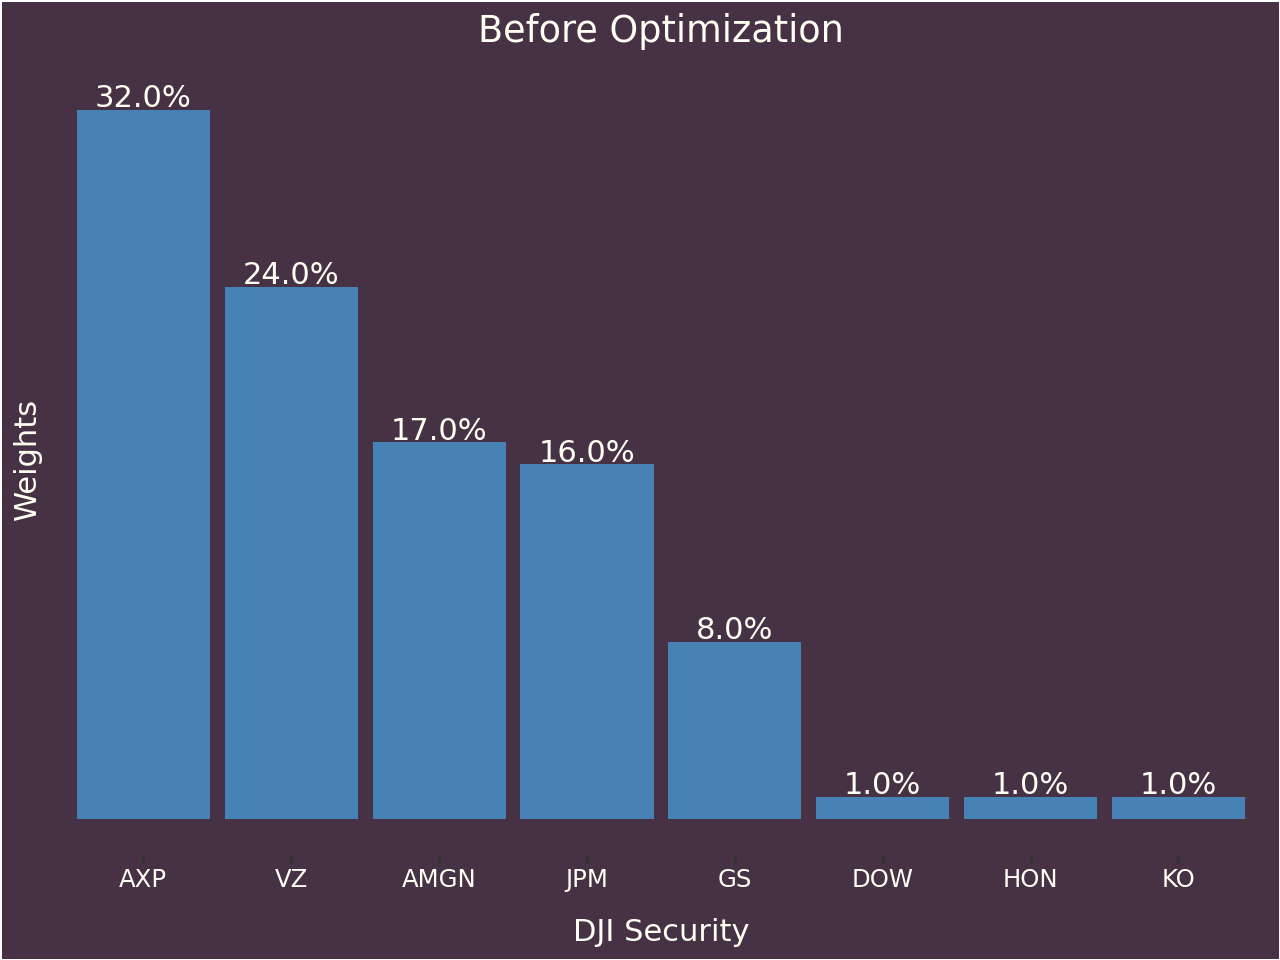

In [124]:
viz_weights_barPlot(np.array(beforeOptimWeights),'Before Optimization')

**iterating over portfolio weights to minimize**<br>

Following similar process as before


In [10]:
best100s=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0:100,:]

In [11]:
import patchworklib as pw 

In [12]:
graph3 = viz_weights_barPlot(result.x, title='Best Weight After Optimization with SLSQP')
g_mat=graph3.draw()

In [13]:
abc=  np.column_stack((result.x, range(30))) 

pd.DataFrame(np.column_stack((abc, range(30))))

np.row_stack((abc, np.column_stack((result.x, ["p2"]*30))  ))    

array([['6.407153219525151e-16', '0.0'],
       ['0.1072860894519823', '1.0'],
       ['0.07532324421638857', '2.0'],
       ['0.09054145473464763', '3.0'],
       ['1.554598325402062e-16', '4.0'],
       ['1.3217126808248018e-16', '5.0'],
       ['4.2565035035787465e-17', '6.0'],
       ['2.3158834442861625e-16', '7.0'],
       ['4.6516067428894914e-17', '8.0'],
       ['5.465846685079876e-16', '9.0'],
       ['1.971332057836342e-17', '10.0'],
       ['0.02618381936293347', '11.0'],
       ['2.207389095603334e-17', '12.0'],
       ['8.353913552646678e-17', '13.0'],
       ['0.09701090528872242', '14.0'],
       ['1.105991442979784e-16', '15.0'],
       ['2.4014693036346644e-17', '16.0'],
       ['0.1229824391144943', '17.0'],
       ['2.055728180830673e-16', '18.0'],
       ['8.31734897919281e-17', '19.0'],
       ['0.036090572977350764', '20.0'],
       ['5.35316400584759e-16', '21.0'],
       ['0.05433624290618884', '22.0'],
       ['1.489499158775093e-16', '23.0'],
       ['2.48846

In [14]:
emptyDataframe = pd.DataFrame({
        'Weights': [],
        'Portfolio': [],
        'Security': []
})

In [15]:
# iterating over 100 best portfolios 
best_result = 0 
best_weights = 0
iter_n = 0
for i,x in enumerate(best100s.values):
    
    #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
    initial_guess = x    
    result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if -result.fun > best_result: 
        iter_n+=1
        portfolio_iter = f'Portfolio # {iter_n}. Sharpe: {-result.fun:.2f}'
        best_result = -result.fun 
        best_weights = result.x   
        mini_df=pd.DataFrame({
            'Weights': best_weights,
            'Portfolio': [portfolio_iter]*30,
            'Security': df_weights.columns[:30]
        })   
        emptyDataframe = pd.concat([emptyDataframe,mini_df])
        
          
        print("Best Sharpe Ratio So Far:", -result.fun)
        


Best Sharpe Ratio So Far: 1.2881776135791279
Best Sharpe Ratio So Far: 1.2881776721035614
Best Sharpe Ratio So Far: 1.288177684020628


In [16]:
p_iteration_best100=emptyDataframe >> \
    mutate(value = np.round(_.Weights,2), variable = _.Security ) >> \
    filter(_.value > 0) >> \
    mutate(value_plot = _.value *100, 
        value_plot2 = (_.value *100).apply(lambda x: str(round(x,0)) + '%') ) >> arrange(-_.value) >>\
        ggplot() + geom_col(aes(x='reorder(variable, -value)',y='value'), fill = 'steelblue') + \
            geom_text(aes(x='variable',y='value',label='value_plot2'), nudge_y =.005, color = '#FFFFF2') +\
            labs(y = 'Weights', x='DJI Security',title='Iteration of Best Optimized Portfolio Found', caption='Optimization made from 100 Best Portfolios initially selected') + \
            theme(
                axis_text_y=element_blank(),
                axis_ticks_y=element_blank(), 
                plot_background=element_rect(fill='#473144'),
                panel_background=element_rect(fill='#473144'),
                text=element_text(color='#FFFFF2'),
                axis_title_x=element_text(margin={'t': 20}),   # Move x-axis label
                panel_grid_major= element_blank(),
                panel_grid_minor=element_blank(),
                strip_text=element_text(color='black')
            )+ \
            facet_wrap("~Portfolio",nrow=2)

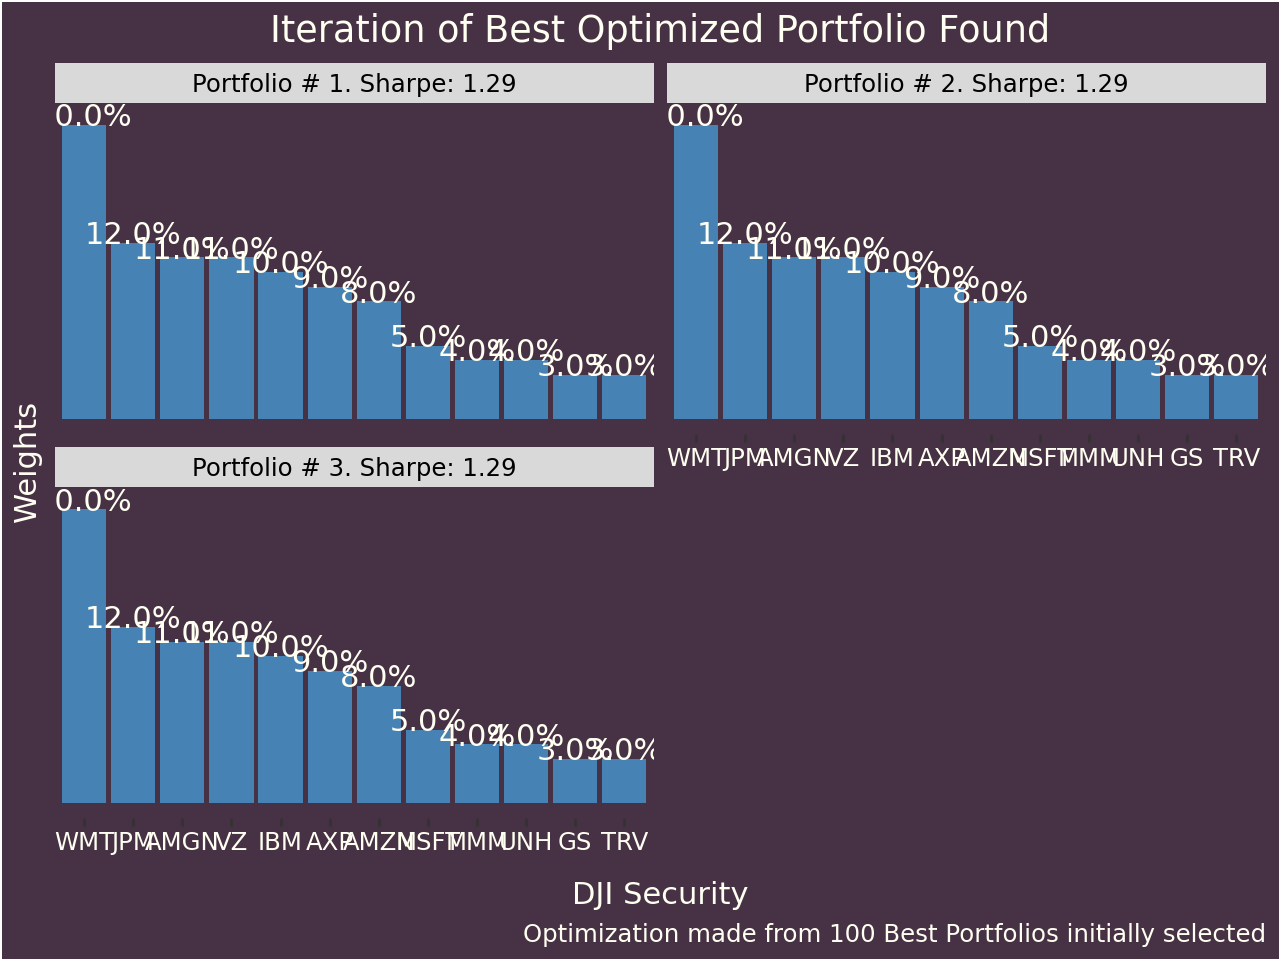

In [17]:
p_iteration_best100

In [291]:
p_iteration_best100.save(filename = 'Iteration Best 100', height=8, width=12, units = 'in', dpi=1000)

In [18]:
table_summary_best100Port=emptyDataframe>> mutate(Weights = np.round(_.Weights,2))>> filter(_.Weights>0) >> arrange(_.Portfolio, -_.Weights) >>\
spread(_, key='Security', value = 'Weights') 


In [19]:
from great_tables import GT,style, loc
from great_tables._formats import fmt_percent
from great_tables._scss import *
from great_tables._options import *

In [ ]:
gt1=GT(table_summary_best100Port).\
    tab_header(title="Best 3 Portfolios After Optimization", subtitle=f"Based on 100 Random States of Best Portfolios").\
        fmt_percent(columns=[x for x in table_summary_best100Port.columns if x != 'Portfolio'],decimals=0).\
            tab_options(
                table_background_color='black',                
                table_border_top_style = 'dotted',
                table_border_top_width=0,
                table_border_bottom_width=0,
                table_border_right_width= 0,
                table_border_left_width= 0 ,
                heading_padding=  0 ,
                heading_padding_horizontal = 0         
                
                ).\
                tab_style(
                    style= style.borders(sides = ['top','bottom'], weight="0px"),
                    locations=loc.body()
                ).tab_source_note(source_note="All Best 3 Portfolios Found were indistinguishable from each other")



In [52]:

#gt1._options.container_padding_y 
gt1.save(file = 'Table Summary Best 100 Port.png', scale=2)

In [53]:
gt1

GT(_tbl_data=                     Portfolio  AMGN  AMZN   AXP    GS  IBM   JPM   MMM  MSFT  \
0  Portfolio # 1. Sharpe: 1.29  0.11  0.08  0.09  0.03  0.1  0.12  0.04  0.05   
1  Portfolio # 2. Sharpe: 1.29  0.11  0.08  0.09  0.03  0.1  0.12  0.04  0.05   
2  Portfolio # 3. Sharpe: 1.29  0.11  0.08  0.09  0.03  0.1  0.12  0.04  0.05   

    TRV   UNH    VZ  WMT  
0  0.03  0.04  0.11  0.2  
1  0.03  0.04  0.11  0.2  
2  0.03  0.04  0.11  0.2  , _body=<great_tables._gt_data.Body object at 0x00000262D2CC9760>, _boxhead=Boxhead([ColInfo(var='Portfolio', type=<ColInfoTypeEnum.default: 1>, column_label='Portfolio', column_align='left', column_width=None), ColInfo(var='AMGN', type=<ColInfoTypeEnum.default: 1>, column_label='AMGN', column_align='right', column_width=None), ColInfo(var='AMZN', type=<ColInfoTypeEnum.default: 1>, column_label='AMZN', column_align='right', column_width=None), ColInfo(var='AXP', type=<ColInfoTypeEnum.default: 1>, column_label='AXP', column_align='right', column_width=None), ColInfo(var='GS', type=<ColInfoTypeEnum.default: 1>, column_label='GS', column_align='right', column_width=None), ColInfo(var='IBM', type=<ColInfoTypeEnum.default: 1>, column_label='IBM', column_align='right', column_width=None), ColInfo(var='JPM', type=<ColInfoTypeEnum.default: 1>, column_label='JPM', column_align='right', column_width=None), ColInfo(var='MMM', type=<ColInfoTypeEnum.default: 1>, column_label='MMM', column_align='right', column_width=None), ColInfo(var='MSFT', type=<ColInfoTypeEnum.default: 1>, column_label='MSFT', column_align='right', column_width=None), ColInfo(var='TRV', type=<ColInfoTypeEnum.default: 1>, column_label='TRV', column_align='right', column_width=None), ColInfo(var='UNH', type=<ColInfoTypeEnum.default: 1>, column_label='UNH', column_align='right', column_width=None), ColInfo(var='VZ', type=<ColInfoTypeEnum.default: 1>, column_label='VZ', column_align='right', column_width=None), ColInfo(var='WMT', type=<ColInfoTypeEnum.default: 1>, column_label='WMT', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x00000262D2C43EF0>, _spanners=Spanners([]), _heading=Heading(title='Best 3 Portfolios After Optimization', subtitle='Based on 100 Random States of Best Portfolios', preheader=None), _stubhead=None, _source_notes=['All Best 3 Portfolios Found were indistinguishable from each other'], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='Portfolio', rownum=0, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='Portfolio', rownum=1, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='Portfolio', rownum=2, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='AMGN', rownum=0, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='AMGN', rownum=1, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='AMGN', rownum=2, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='AMZN', rownum=0, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom'], color='#000000', style='solid', weight='0px')]), StyleInfo(locname=LocBody(columns=None, rows=None), grpname=None, colname='AMZN', rownum=1, colnum=None, styles=[CellStyleBorders(sides=['top', 'bottom

In [269]:
# port return best weight
portfolio_return(best_weights,training_pct_change)

0.05291380961733473

In [270]:
# port return before iteration
portfolio_return(result.x,training_pct_change)

0.05291706993262695

In [22]:
# port return Dow Jones
port_returnDJI=portfolio_return(np.array([1/30 for x in range(30)]),training_pct_change)
port_returnDJI

0.02525422851968323

In [23]:
# best portfolio is 6% more volatile than the Dow Jones. But provides twice the return
portfolio_risk(best_weights,training_pct_change)/portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)

1.0604120036046418

In [24]:
port_risk_DJI= portfolio_risk(np.array([1/30 for x in range(30)]),training_pct_change)
port_risk_DJI

0.03873633994871643

Is there a portfolio that provides similar return but lower risk? Nope. El DJI es el portafolio que ofrece la mayor diversidad y por lo tanto el menor riesgo

In [16]:
from siuba import *
from plotnine import *

**iterating over 100 random portfolios** <br>

In [25]:
np.random.seed(123)
allPortfolios = df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True)
random100Portfolios=np.random.choice(allPortfolios.shape[0],size=100,replace=False)

In [26]:
emptyDataframe_randomPort = pd.DataFrame({
        'Weights': [],
        'Portfolio': [],
        'Security': []
})

In [27]:
# iterating over 100 random portfolios 
best_result = 0 
best_weights = 0
iter_n = 0

for i,x in enumerate(random100Portfolios):
    
    #initial_guess = [1. / returns.shape[1]] * returns.shape[1]
    initial_guess = allPortfolios.iloc[x,:]    
    result = minimize(sharpe_ratio, initial_guess, args=(training_pct_change,), method='SLSQP', bounds=bounds, constraints=constraints)
    
    if -result.fun > best_result: 
        iter_n+=1
        portfolio_iter = f'Portfolio # {iter_n}. Sharpe: {-result.fun:.2f}'
        best_result = -result.fun 
        best_weights = result.x
        mini_df=pd.DataFrame({
            'Weights': best_weights,
            'Portfolio': [portfolio_iter]*30,
            'Security': df_weights.columns[:30]
        })   
        emptyDataframe_randomPort = pd.concat([emptyDataframe_randomPort,mini_df])

        print("Best Sharpe Ratio So Far:", -result.fun)

Best Sharpe Ratio So Far: 1.2881775320950857
Best Sharpe Ratio So Far: 1.288177668844672
Best Sharpe Ratio So Far: 1.2881776759755965


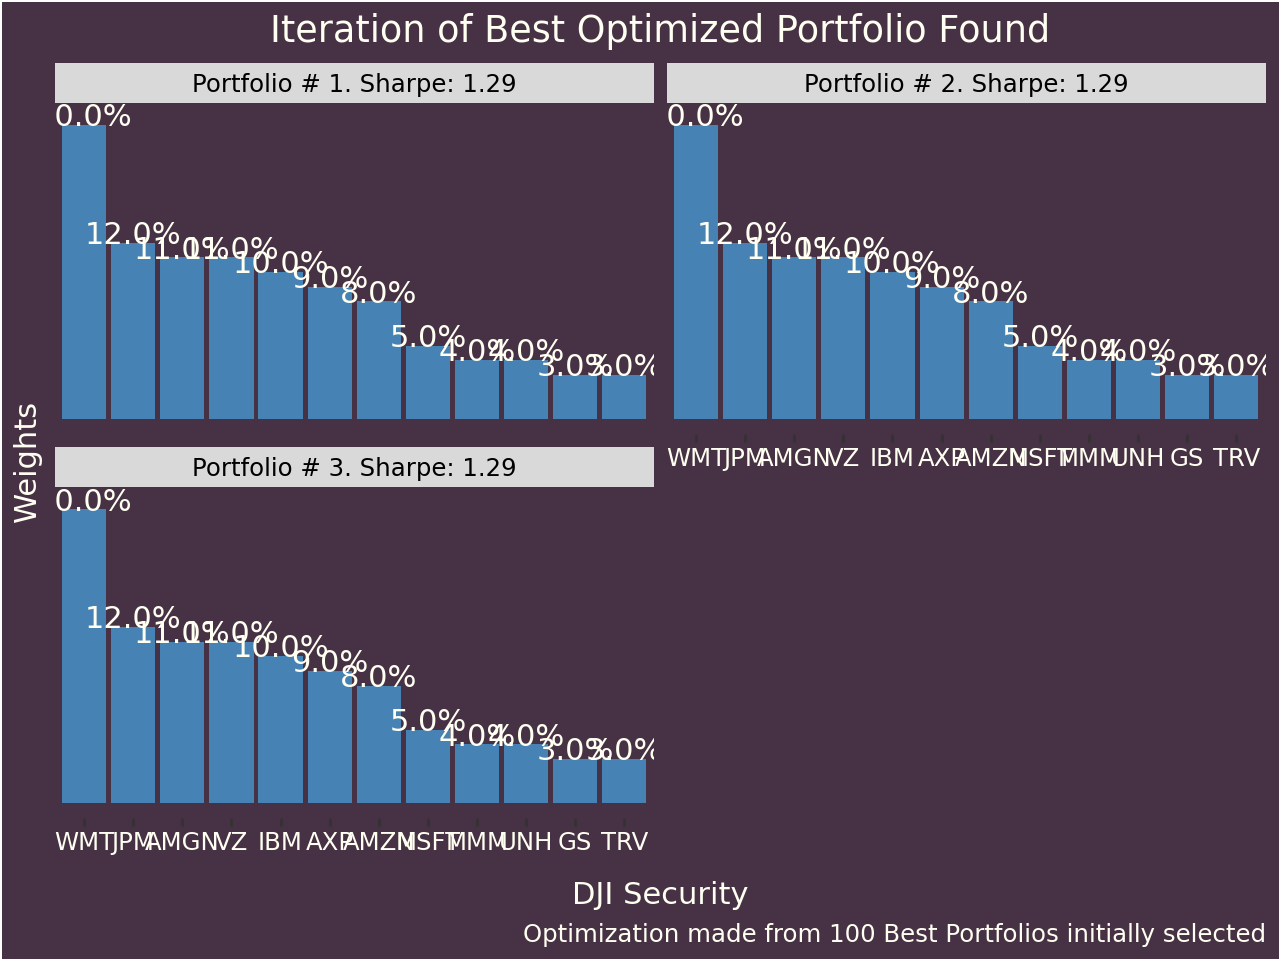

In [28]:
p_iteration_random100=emptyDataframe_randomPort >> \
    mutate(value = np.round(_.Weights,2), variable = _.Security ) >> \
    filter(_.value > 0) >> \
    mutate(value_plot = _.value *100, 
        value_plot2 = (_.value *100).apply(lambda x: str(round(x,0)) + '%') ) >> arrange(-_.value) >>\
        ggplot() + geom_col(aes(x='reorder(variable, -value)',y='value'), fill = 'steelblue') + \
            geom_text(aes(x='variable',y='value',label='value_plot2'), nudge_y =.005, color = '#FFFFF2') +\
            labs(y = 'Weights', x='DJI Security',title='Iteration of Best Optimized Portfolio Found', caption='Optimization made from 100 Best Portfolios initially selected') + \
            theme(
                axis_text_y=element_blank(),
                axis_ticks_y=element_blank(), 
                plot_background=element_rect(fill='#473144'),
                panel_background=element_rect(fill='#473144'),
                text=element_text(color='#FFFFF2'),
                axis_title_x=element_text(margin={'t': 20}),   # Move x-axis label
                panel_grid_major= element_blank(),
                panel_grid_minor=element_blank(),
                strip_text=element_text(color='black')
            )+ \
            facet_wrap("~Portfolio",nrow=2)
p_iteration_random100

In [290]:
p_iteration_random100.save(filename = 'Iteration Random 100', height=8, width=12, units = 'in', dpi=1000)

# Other Optimization Algorithms

Simmaneal Lib

In [126]:
import numpy as np
import pandas as pd
from simanneal import Annealer

# Assuming you have your daily returns DataFrame ready
# returns = pd.DataFrame(...)

class PortfolioOptimization(Annealer):
    def __init__(self, state, returns):
        self.returns = returns
        super().__init__(state)

    def move(self):
        """ Randomly adjust a weight """
        i = np.random.randint(0, len(self.state))
        change = np.random.uniform(-0.1, 0.1)
        self.state[i] = min(max(self.state[i] + change, 0), 1)
        self.state = self.state / np.sum(self.state)

    def energy(self):
        return sharpe_ratio(self.state, self.returns)

# Define your initial state (weights)
initial_state = beforeOptimWeights  # Equal weights for simplicity

optimizer = PortfolioOptimization(initial_state, training_pct_change)
optimizer.steps = 10000
best_state, best_energy = optimizer.anneal()

print("Optimal weights:", best_state)
print("Optimal Sharpe ratio:", -best_energy)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.64    98.00%    45.00%     0:00:05     0:00:00

Optimal weights: AAPL    0.000000
AMGN    0.157944
AMZN    0.000000
AXP     0.297305
BA      0.000000
CAT     0.000000
CRM     0.000000
CSCO    0.000000
CVX     0.000000
DIS     0.000000
DOW     0.000000
GS      0.074326
HD      0.000000
HON     0.009291
IBM     0.000000
INTC    0.000000
JNJ     0.000000
JPM     0.148653
KO      0.009291
MCD     0.000000
MMM     0.077723
MRK     0.000000
MSFT    0.000000
NKE     0.000000
PG      0.000000
TRV     0.000000
UNH     0.062071
V       0.000000
VZ      0.163397
WMT     0.000000
Name: 7326, dtype: float64
Optimal Sharpe ratio: 1.1054361162350657


In [314]:
best100s.iloc[0,:]

AAPL    0.00
AMGN    0.17
AMZN    0.00
AXP     0.32
BA      0.00
CAT     0.00
CRM     0.00
CSCO    0.00
CVX     0.00
DIS     0.00
DOW     0.01
GS      0.08
HD      0.00
HON     0.01
IBM     0.00
INTC    0.00
JNJ     0.00
JPM     0.16
KO      0.01
MCD     0.00
MMM     0.00
MRK     0.00
MSFT    0.00
NKE     0.00
PG      0.00
TRV     0.00
UNH     0.00
V       0.00
VZ      0.24
WMT     0.00
Name: 0, dtype: float64

In [320]:
overall_best_state = []
overall_best_energy = 0 
for p in range(best100s.shape[0]):
    
    optimizer = PortfolioOptimization(best100s.iloc[p,:], training_pct_change)
    optimizer.steps = 10000
    best_state, best_energy = optimizer.anneal()

    if -best_energy > overall_best_energy: 
        overall_best_energy = -best_energy 
        overall_best_state = best_state 

print(overall_best_energy)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.55    99.00%    37.00%     0:00:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.49   100.00%    45.00%     0:00:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.74   100.00%    39.00%     0:00:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.48   100.00%    45.00%     0:00:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.53    99.00%    46.00%     0:00:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.63    99.00%    40.00%     0:00:05     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000         -0.39    99.00%    44.00%     0:00:05     0:00:00 Temperature 

1.1346867493126715


Optimizing Annealer Hyperparameters

In [127]:
auto_schedule = optimizer.auto(minutes=1) 

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000         -1.29    30.30%     0.00%     0:00:47    -1:59:18

In [128]:
auto_schedule

{'tmax': 0.45, 'tmin': 8.7e-08, 'steps': 110000, 'updates': 100}

In [129]:
optimizer.set_schedule(auto_schedule)

In [130]:
best_state, best_energy = optimizer.anneal()

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00000         -1.29    29.27%     0.00%     0:00:57     0:00:00

Con simmaneal encontramos el mejor sharpe ratio de 1.28 despues de utilizar la optimizacion de hyperparameters

In [131]:
-best_energy, best_state

(1.2881769092515634,
 AAPL    0.000000
 AMGN    0.107184
 AMZN    0.075359
 AXP     0.090644
 BA      0.000000
 CAT     0.000000
 CRM     0.000000
 CSCO    0.000000
 CVX     0.000000
 DIS     0.000000
 DOW     0.000000
 GS      0.025976
 HD      0.000000
 HON     0.000000
 IBM     0.097101
 INTC    0.000000
 JNJ     0.000000
 JPM     0.123093
 KO      0.000000
 MCD     0.000000
 MMM     0.035913
 MRK     0.000000
 MSFT    0.054483
 NKE     0.000000
 PG      0.000000
 TRV     0.033072
 UNH     0.040044
 V       0.000000
 VZ      0.112692
 WMT     0.204437
 Name: 7326, dtype: float64)

__Dual Annealing fro scipi.optimize__

In [30]:
from scipy.optimize import dual_annealing

In [353]:
import numpy as np
import pandas as pd
from scipy.optimize import dual_annealing

# Load or generate your returns data
# Here we create a dummy DataFrame; replace this with your actual returns data

returns = training_pct_change # 41 days of returns for 30 stocks

# Set the bounds for the weights (0 to 1)
bounds = [(0, 1) for _ in range(returns.shape[1])]

# Define a penalty function for weights sum constraint
def penalty(weights):
    return 1000 * abs(np.sum(weights) - 1)

# Cost function with penalty
def cost_function(weights, returns):
    return sharpe_ratio(weights, returns) + penalty(weights)
# Constraint for the sum of weights to be 1
#constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Custom hyperparameters
hyperparameters = {
    'initial_temp': 5230.0,  # Initial temperature
    'restart_temp_ratio': 2e-5,  # Reheating parameter
    'maxiter': 10000  }

# Optimize using dual_annealing
result = dual_annealing(lambda weights: cost_function(weights, returns),
                        bounds=bounds, **hyperparameters)

# Optimal weights
optimal_weights = result.x
print("Optimal Weights: ", optimal_weights)

# Verify the sum of weights
print("Sum of Weights: ", np.sum(optimal_weights))
print(f"Result of function {-result.fun}")


Optimal Weights:  [0.01416438 0.04383864 0.0534729  0.05118739 0.         0.08766051
 0.02949489 0.00153009 0.00417072 0.         0.05839442 0.06430763
 0.02400285 0.         0.14728243 0.01506653 0.00971639 0.03014742
 0.01286254 0.         0.03189457 0.00887947 0.03123479 0.01237813
 0.00966776 0.05086104 0.03288401 0.03848054 0.03917118 0.09724879]
Sum of Weights:  0.9999999981959581
Result of function 0.969943534560618


__Bayesian Optimization__ <br>
Ahora utilizando Bayesian Optimization from Lesson 6 de Optimizacion

In [44]:
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [47]:
import numpy as np
import pandas as pd
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Your Sharpe ratio functions
def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 41

def portfolio_risk(weights, returns):
    cov_matrix = returns.cov() * 41
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0):
    port_return = portfolio_return(weights, returns)
    port_risk = portfolio_risk(weights, returns)
    if port_return == 0: 
        return 0 
    else :
        return - (port_return - risk_free_rate) / port_risk

# Penalty for the sum of weights constraint
def penalty(weights):
    return 1000 * abs(np.sum(weights) - 1)

# Cost function with penalty
def cost_function(weights, returns):
    sr = sharpe_ratio(weights, returns)
    penalty_value = penalty(weights)
    total_cost = sr + penalty_value
    if np.isnan(total_cost):
        print(f"Weights: {weights}")
        print(f"Sharpe Ratio: {sr}")
        print(f"Penalty: {penalty_value}")
    return total_cost

# Dummy returns data (replace with your actual returns)
returns = training_pct_change

# Define the search space
space = [Real(0.0, 1.0, name=f'w{i}') for i in range(returns.shape[1])]

# Optimize
@use_named_args(space)
def objective(**kwargs):
    weights = np.array(list(kwargs.values()))
    return cost_function(weights, returns)

# Perform the optimization
res = gp_minimize(objective, space, n_calls=200, x0=[1/30 for x in range(30)],
                  acq_func="EI", xi=0.01)

# Optimal weights
optimal_weights = np.array(res.x)
print("Optimal Weights: ", optimal_weights)

# Verify the sum of weights
print("Sum of Weights: ", np.sum(optimal_weights))
print(f"Best Sharpe {res.fun}")


Optimal Weights:  [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333]
Sum of Weights:  1.0
Best Sharpe -0.6519518507199608


In [292]:
from copy import deepcopy
best1_weights= deepcopy( result.x)

In [293]:
init_guess=df_weights.sort_values('sharpe',ascending=False).loc[:,"AAPL":"WMT"].reset_index(drop=True).iloc[0,:]

In [294]:
init_guess=np.array( init_guess)

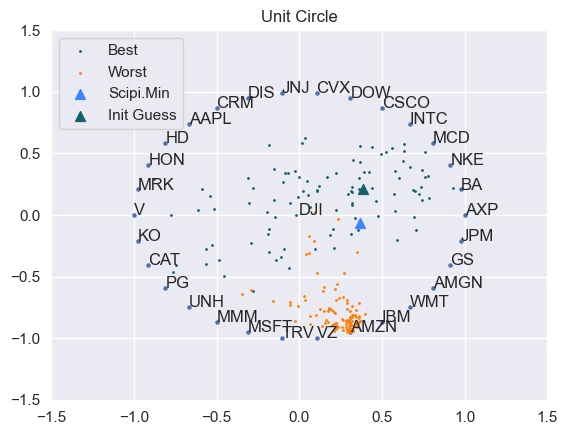

In [295]:

# PLOTTING UNICIRCLE

unitCircleDf['securities'] =\
df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:1000,:].\
        loc[:,"AAPL":"WMT"].\
            rank(axis=1, method='max',ascending=False).\
            apply(lambda x: np.count_nonzero(x<=5),axis=0).sort_values().index


#%%
nbr_portfolios = 100

best1000portfolios = df_weights.\
    sort_values('sharpe',ascending=False).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

worst1000portfolios = df_weights.\
    sort_values('sharpe',ascending=True).reset_index(drop=True).\
    iloc[:nbr_portfolios,:]

bestPort_coord = pd.DataFrame(
    {
        'best_length': [np.array(x).dot(unitCircleDf.lengths) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values],
        'best_height': [np.array(x).dot(unitCircleDf.heights) for x in best1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)

worstPort_coord = pd.DataFrame(
    {
        'worst_length': [np.array(x).dot(unitCircleDf.lengths) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values],
        'worst_height': [np.array(x).dot(unitCircleDf.heights) for x in worst1000portfolios.loc[:,"AAPL":"WMT"].values]
    }
)
#[value for value in best1_weights]
minimize_best1_coord =  pd.DataFrame(
    {
        'best_length': [best1_weights.dot(unitCircleDf.lengths)],
        'best_height': [best1_weights.dot(unitCircleDf.heights)]
    }
)

init_guess_coord =  pd.DataFrame(
    {
        'best_length': [init_guess.dot(unitCircleDf.lengths)],
        'best_height': [init_guess.dot(unitCircleDf.heights)]
    }
)

# plotting top n portfolios (blue), and bottom (1000) portfolios


plt.scatter(x=unitCircleDf.lengths, y=unitCircleDf.heights, s=5, color='b')
# Add labels
for i, txt in enumerate(unitCircleDf['securities']):
    plt.annotate(txt, (unitCircleDf['lengths'][i], unitCircleDf['heights'][i]))

plt.scatter(x=bestPort_coord.best_length, y=bestPort_coord.best_height, s=1, color='#15616d', label = 'Best')
plt.scatter(x=worstPort_coord.worst_length, y=worstPort_coord.worst_height, s=1, color='#ff7d00', label = 'Worst')
plt.scatter(x=minimize_best1_coord.best_length, y=minimize_best1_coord.best_height, s=50, color='#3a86ff', label = 'Scipi.Min',marker='^')
plt.scatter(x=init_guess_coord.best_length, y=init_guess_coord.best_height, s=50, color='#15616d', label = 'Init Guess',marker='^')
plt.annotate('DJI', (0, 0))
# Adding legend with bigger dots
plt.legend(markerscale=1)    



plt.xlim(-1.5, 1.5)
plt.ylim(-1.5,1.5)
plt.title('Unit Circle')
plt.show()


Note that sharpe ratio from the new optimized portfolio is 1.28 compared vs the best from random port weights of 1.07

In [86]:
df_weights.sort_values('sharpe',ascending=False).head(1)

,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WMT,port_return,port_risk,sharpe
14652,0.0,0.17,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.24,0.0,0.058013,0.053803,1.078258


In [23]:
for row in [best1_weights]: 
    iter=training_pct_change.dot(row)
    i_mean=iter.mean()
    i_sd = iter.std()
    mean2months=i_mean*41
    sd2_months=i_sd * np.sqrt(41)
    print(mean2months/sd2_months)

1.2881774429622443


# Graphing Portfolio Performance

We will graph the weighted returns of the best portfolio and the dow jones

In [24]:
returns_port_training=pd.DataFrame({
    'bestPort': training_pct_change.dot(result.x),
    'DJI':training_pct_change.dot(np.array([1/30 for x in range(30)]))
})


In [25]:

def fn_dollarChangePortfolio(fn_portReturn: np.array,
                             init_dollar: int = 1_000_000 )->list[float]:    
    """ 
        This function will return the variability of money in time given portfolio returns as input and a dollar amt
    """    
    from copy import deepcopy 
    dollar_current = deepcopy(init_dollar)
    dollar_changes = []

    for x in fn_portReturn: 
        dollar_current*=(1+x)
        dollar_changes.append(dollar_current)

    return dollar_changes

In [26]:
fn_dollarChangePortfolio(returns_port_training.bestPort)

[991944.3093844386,
 991542.6110332963,
 999244.9158052452,
 1011522.6668638657,
 1010115.1596183744,
 1003570.1571237816,
 1006295.2020871241,
 1010641.877234247,
 1010217.7770938122,
 1000676.5662619657,
 996614.9250964322,
 988251.9408439543,
 990717.3708013648,
 991467.1488106683,
 984762.4451121431,
 990458.7614976444,
 984582.8885555211,
 988450.2890767443,
 994095.2317534469,
 1005779.7469961978,
 1005671.57558362,
 1006090.7301012675,
 1007107.7764003852,
 1007107.7764003852,
 1001480.2015531018,
 997309.7183477673,
 1000538.2847649388,
 1003389.6456752908,
 1011837.2620670554,
 1011094.090002749,
 1010829.0404639035,
 1021377.7057230088,
 1014671.7769777923,
 1010605.906386558,
 1009110.4470340657,
 1011720.8929886117,
 999330.1546341975,
 996061.117000069,
 997546.0041390994,
 987424.9095884417,
 984045.8069331511,
 987706.3265390757,
 979319.4797194035,
 977126.9446313524,
 964467.0688265706,
 971596.4932975695,
 971744.7562159102,
 975107.7398716361,
 978694.4516007428,
 98

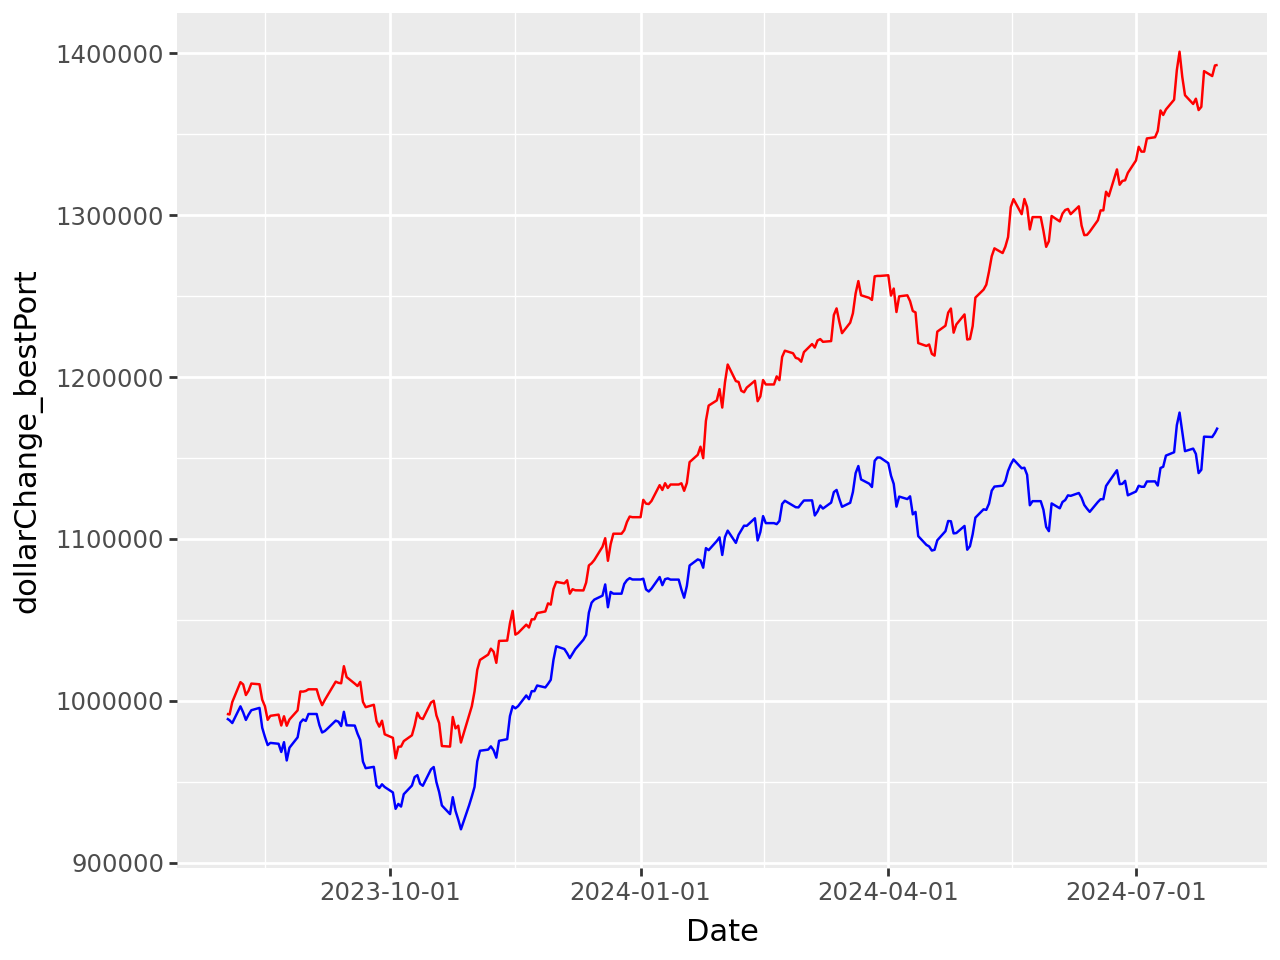

In [32]:
returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> _.reset_index()>> ggplot() + geom_line(aes(x='Date',y='dollarChange_bestPort'), color='red')+\
geom_line(aes(x='Date',y='dollarChange_DJI'), color='blue')

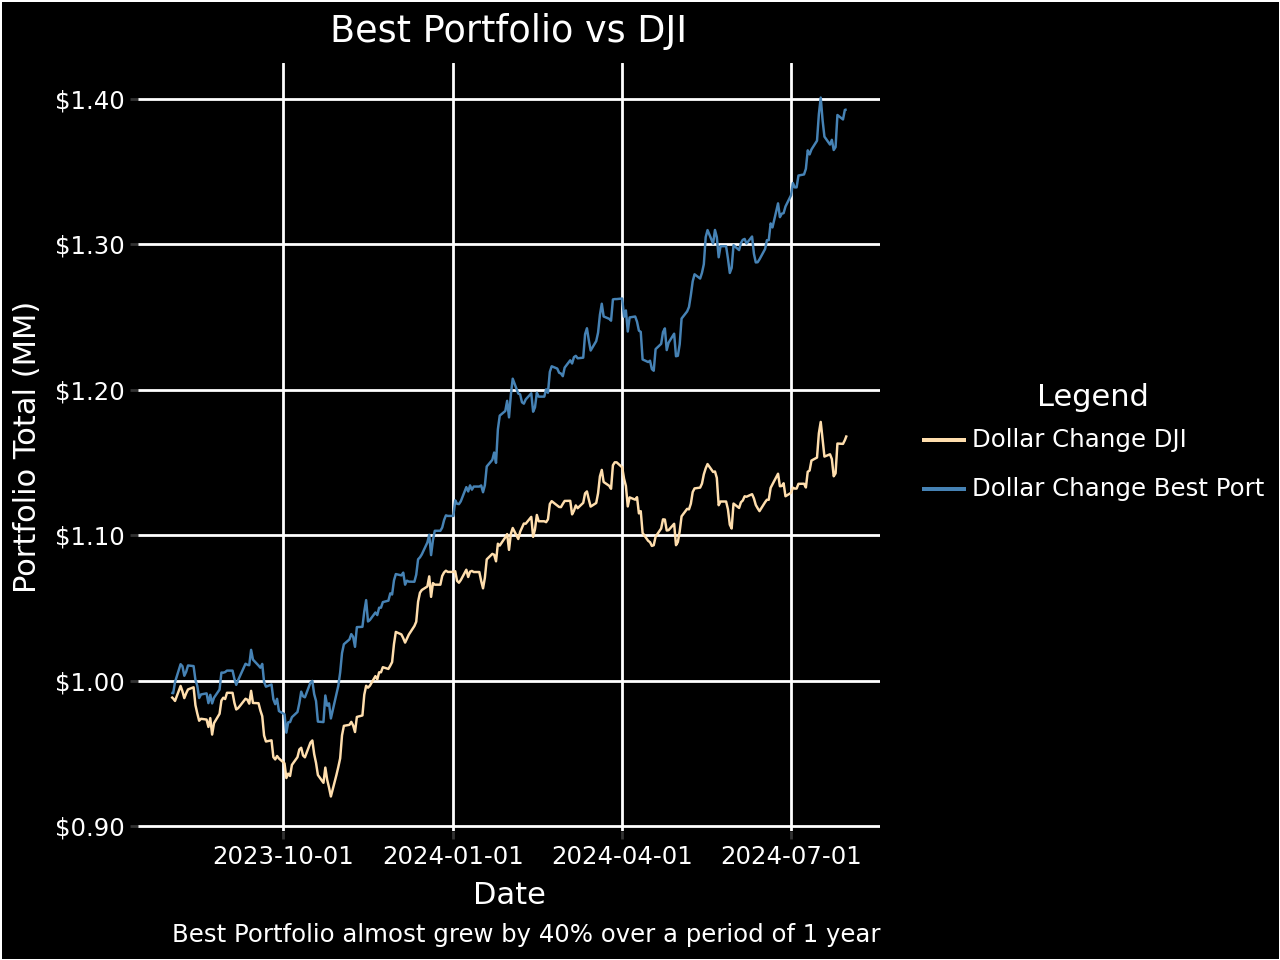

In [85]:
graph_bestPortfolio_vs_DJI=returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> _.reset_index() >> select(_[0,3,4]) >> _.melt(id_vars = 'Date') >> \
mutate(value = _.value/1_000_000)>>\
ggplot() + geom_line(aes(x='Date', y='value', color='variable'))+\
scale_color_manual(
        values={
            'dollarChange_DJI': 'navajowhite',
            'dollarChange_bestPort': 'steelblue'
        },
        labels={
            'dollarChange_DJI': 'Dollar Change DJI',
            'dollarChange_bestPort': 'Dollar Change Best Port'
        }
    ) + scale_y_continuous(labels=lambda l: [f'${v:,.2f}' for v in l])+ \
    labs(y='Portfolio Total (MM)', title = 'Best Portfolio vs DJI', color='Legend', caption='Best Portfolio almost grew by 40% over a period of 1 year') + theme(plot_background=element_rect(fill='black'), # outside plot
                                                                    text=element_text(color='white'), # all text                                                                    
                                                                    panel_background=element_rect(fill='black'), # inside plot 
                                                                    panel_grid_minor=element_blank(), # take out minor grid 
                                                                    legend_background=element_rect(fill='black'),                                                                     
                                                                    legend_key=element_rect(fill='black'),
                                                                    legend_title=element_text(ha='center')
                                                                    )
graph_bestPortfolio_vs_DJI

In [84]:
graph_bestPortfolio_vs_DJI.save(filename = 'Best Portfolio vs DJI', height=5, width=10, units = 'in', dpi=1000)

Text(0.5, 1.0, '1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

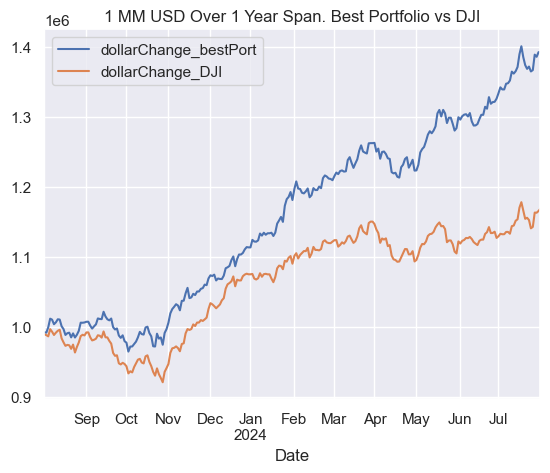

In [27]:
returns_port_training >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> select(2,3)>> _.plot()
plt.title('1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

In [94]:
## 41 rows of daily pct change in aug and sept 2024
testing_beginAug=df_ticker_price1["2024-07-31":"2024-09-30"].copy()

testing_Pctchange=testing_beginAug.pct_change().dropna()

In [97]:


returns_port_testing=pd.DataFrame({
    'bestPort': testing_Pctchange.dot(result.x),
    'DJI':testing_Pctchange.dot(np.array([1/30 for x in range(30)]))
})

Text(0.5, 1.0, '1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

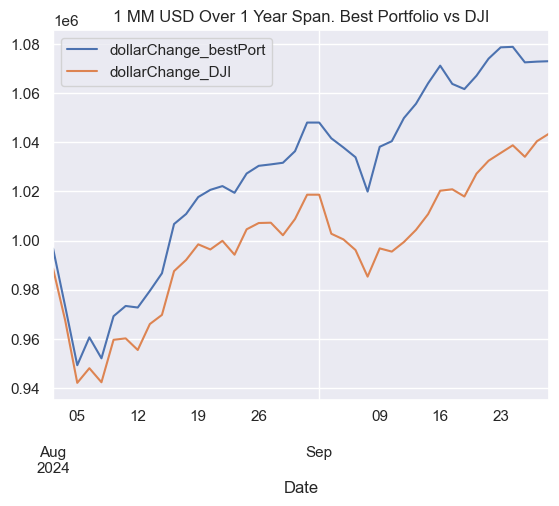

In [99]:
returns_port_testing >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> select(2,3)>> _.plot()
plt.title('1 MM USD Over 1 Year Span. Best Portfolio vs DJI')

<Axes: xlabel='Date'>

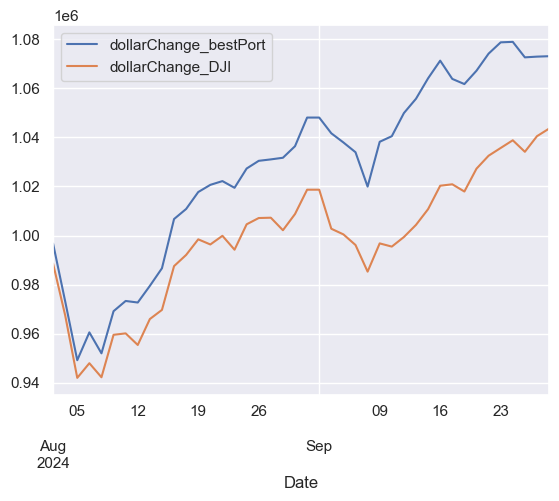

In [105]:


returns_port_testing >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> select(2,3)>> _.plot()


In [115]:
#%% 
returns_port_testing >> mutate(
    dollarChange_bestPort = _.bestPort.pipe(fn_dollarChangePortfolio),
    dollarChange_DJI = _.DJI.pipe(fn_dollarChangePortfolio)
) >> \
summarize(
    bestPortReturn = _.dollarChange_bestPort[-1]/1_000_000-1,
    DJI_Return = _.dollarChange_DJI[-1]/1_000_000-1,
    bestPort_Risk = _.bestPort.std()*np.sqrt(41),
    DJI_Risk = _.DJI.std()*np.sqrt(41)
)

,bestPortReturn,DJI_Return,bestPort_Risk,DJI_Risk
0,0.073036,0.043547,0.058278,0.05859


## Investing 1 MM at the Beginning with no Portfolio Mgmt (not keeping same weight throughout)

In [128]:
training_pct_change 
dollar_init = 1_000_000
distro_dollar=result.x * dollar_init #


array([1.22309061e-10, 1.07286398e+05, 7.53232916e+04, 9.05409223e+04,
       1.40624124e-09, 8.72460385e-11, 3.26889853e-10, 2.14730123e-10,
       3.10678507e-10, 1.49528392e-10, 7.67735688e-10, 2.61841033e+04,
       1.29368179e-10, 5.31157252e-10, 9.70107720e+04, 3.58857374e-10,
       8.38583990e-10, 1.22982722e+05, 1.95819265e-11, 3.75172458e-10,
       3.60905330e+04, 2.12101344e-10, 5.43363981e+04, 1.11013191e-09,
       3.15325235e-11, 3.28326831e+04, 4.01209716e+04, 1.18315344e-10,
       1.12648158e+05, 2.04643047e+05])

In [146]:
columns_index={x:i for i,x in enumerate(training_pct_change.columns)}

training_pct_change.apply(fn_dollarChangePortfolio,init_dollar= 10,axis=0)

resultingDf=training_pct_change.apply(lambda theColumn : fn_dollarChangePortfolio(theColumn, distro_dollar[columns_index[theColumn.name]] ))

<Axes: xlabel='Date'>

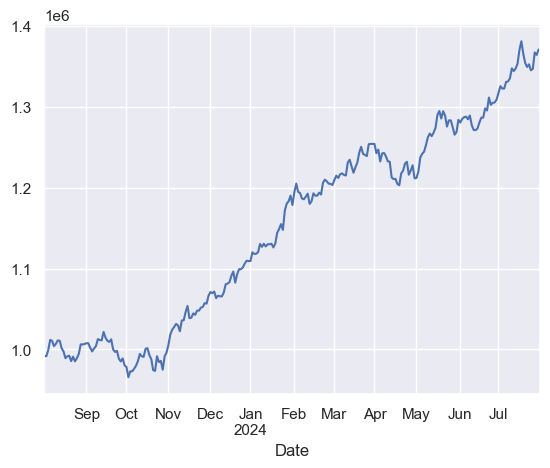

In [154]:
resultingDf.apply(sum,axis=1).plot()

### sig paso: hacer ese ultimo proceso una funcion